# Project Objective

The objective is to build and test different classification models that will use banking data to predict whether a customer will churn. If a customer churns, it means they left the bank and took their business elsewhere. If we can predict customers who are likely to churn, we can take measures to retain them before they do. These measures could be promotions, discounts, or other incentives to boost customer satisfaction and, therefore, retention.

In [1]:
#! pip install pycaret

In [2]:
#! pip install shap

In [3]:
#! pip install ydata-profiling

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ydata_profiling as ydp

from sklearn.preprocessing import MinMaxScaler

from pycaret.classification import *

In [5]:
# Read in data
url = 'https://raw.githubusercontent.com/adacert/churn/main/Churn_Modelling.csv'
df_original = pd.read_csv(url)
df_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
# Create a new df that drops RowNumber, CustomerId, Surname, and Gender cols
churn_df = df_original.drop(['RowNumber', 'CustomerId', 'Surname'], 
                            axis=1)

In [7]:
churn_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## EDA

In [8]:
profile = ydp.ProfileReport(churn_df, title='Churn Data Report', explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

After performing EDA, a couple of questions arise:

The data appears to be a snapshot as some point in time e.g. the balance is for a given date which leaves a lot of questions:

- What date is it and of what relevance is this date

- Would it be possible to obtain balances over a period of time as opposed to a single date.

- There are customers who have exited but still have a balance in their account! What would this mean? Could they have exited from a product and not the bank?

- What does being an active member mean and are there difference degrees to it? Could it be better to provide transaction count both in terms of credits and debits to the account instead?
- A break down to the products bought into by a customer could provide more information topping listing of product count

For this project, we proceed to model without context even though typically having context and better understanding of the data extraction process would give better insight and possibly lead to better and contextual results of the modelling process

In [9]:
# Drop 0 values from Balance
df_original = df_original[df_original['Balance'] != 0]


In [10]:
df_original

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,9992,15769959,Ajuluchukwu,597,France,Female,53,4,88381.21,1,1,0,69384.71,1
9993,9994,15569266,Rahman,644,France,Male,28,7,155060.41,1,1,0,29179.52,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [11]:
# Check class balance
df_original['Exited'].value_counts()

0    4846
1    1537
Name: Exited, dtype: int64

<AxesSubplot:>

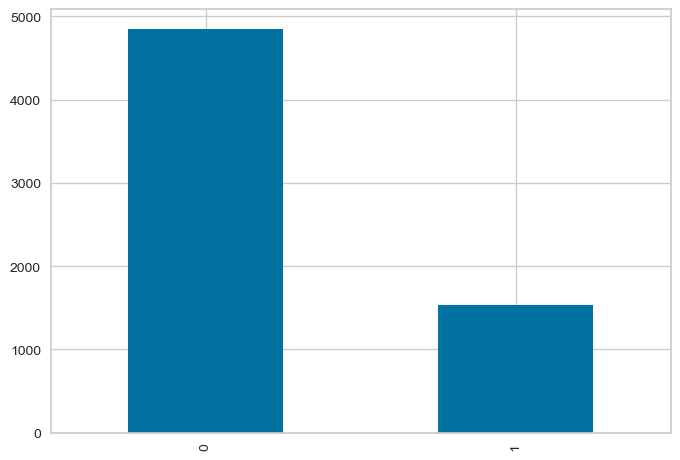

In [12]:
# Visualize class balance
df_original['Exited'].value_counts().plot(kind='bar')

In [13]:
# Dummy encode categorical variables
churn_df = pd.get_dummies(churn_df, drop_first=True)

In [14]:
churn_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [15]:
s = setup(churn_df, target = 'Exited', session_id = 123,   
                  remove_multicollinearity = True, multicollinearity_threshold = 0.95, normalize=True, transformation=True)

,Description,Value
0,Session id,123
1,Target,Exited
2,Target type,Binary
3,Original data shape,"(10000, 12)"
4,Transformed data shape,"(10000, 12)"
5,Transformed train set shape,"(7000, 12)"
6,Transformed test set shape,"(3000, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


In [16]:
# Compare models
compare_models(sort = 'F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8591,0.8473,0.4931,0.7304,0.5878,0.5067,0.5215,0.5900
gbc,Gradient Boosting Classifier,0.8621,0.8614,0.4664,0.7685,0.5795,0.5029,0.5259,0.5340
xgboost,Extreme Gradient Boosting,0.8487,0.8314,0.4741,0.6880,0.5606,0.4730,0.4854,0.5020
ada,Ada Boost Classifier,0.8531,0.8429,0.4552,0.7238,0.5578,0.4753,0.4942,0.5120
rf,Random Forest Classifier,0.8570,0.8443,0.4418,0.7577,0.5575,0.4791,0.5043,0.5120
et,Extra Trees Classifier,0.8533,0.8369,0.4412,0.7333,0.5503,0.4692,0.4911,0.5420
dt,Decision Tree Classifier,0.7859,0.6772,0.4937,0.4760,0.4839,0.3491,0.3496,0.4790
qda,Quadratic Discriminant Analysis,0.8263,0.8068,0.3998,0.6145,0.4836,0.3849,0.3982,0.4980
nb,Naive Bayes,0.8089,0.7681,0.3346,0.5533,0.4161,0.3101,0.3246,0.4790
knn,K Neighbors Classifier,0.8126,0.7428,0.3107,0.5737,0.4026,0.3032,0.3234,0.5110


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [17]:
# Create model
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8614,0.8667,0.4930,0.7368,0.5907,0.5112,0.5262
1,0.8786,0.8690,0.5211,0.8132,0.6352,0.5665,0.5867
2,0.8557,0.8524,0.5141,0.6952,0.5911,0.5059,0.5144
3,0.8643,0.8743,0.5423,0.7196,0.6185,0.5379,0.5459
4,0.8500,0.8687,0.5105,0.6759,0.5817,0.4924,0.4996
5,0.8643,0.8634,0.4965,0.7553,0.5992,0.5216,0.5383
6,0.8614,0.8215,0.4545,0.7738,0.5727,0.4966,0.5216
7,0.8386,0.8196,0.4476,0.6531,0.5311,0.4377,0.4491
8,0.8529,0.8126,0.4755,0.7083,0.5690,0.4844,0.4984


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [18]:
# Analyze model
evaluate_model(lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

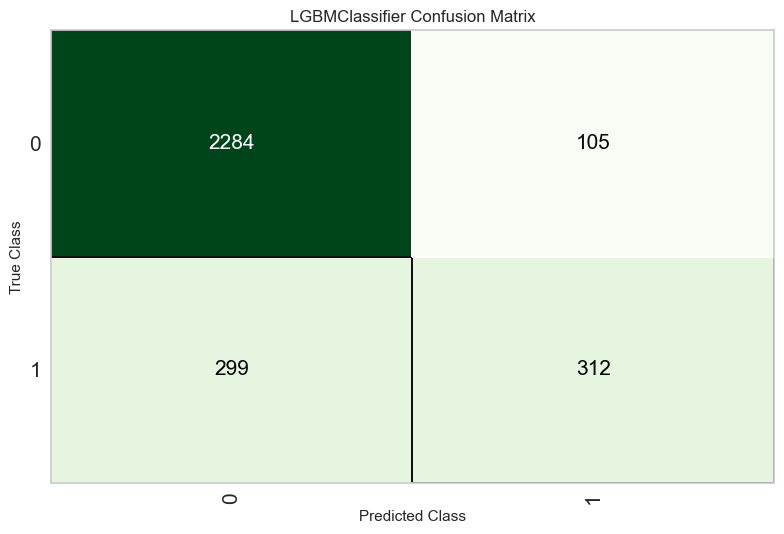

In [19]:
# Plot confusion matrix
plot_model(lightgbm, plot = 'confusion_matrix')

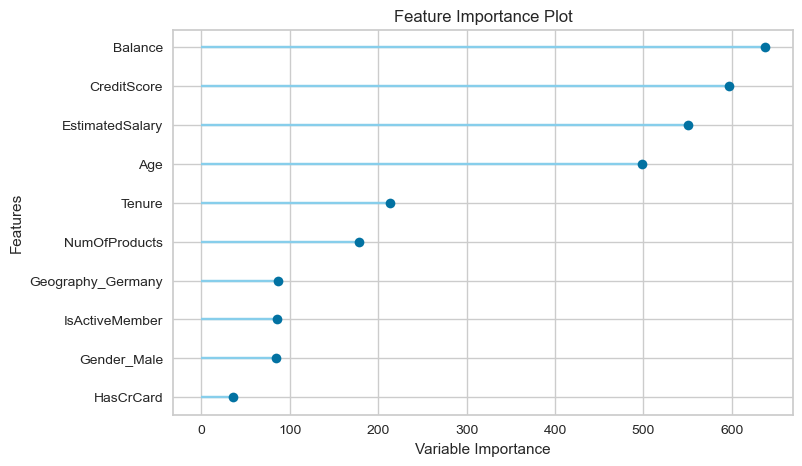

In [20]:
# Plot feature importance
plot_model(lightgbm, plot = 'feature')

In [21]:
# Tune model
tuned_lightgbm = tune_model(lightgbm, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8571,0.8663,0.4648,0.7333,0.5690,0.4885,0.5067
1,0.8700,0.8843,0.5070,0.7742,0.6128,0.5387,0.5561
2,0.8671,0.8556,0.5211,0.7475,0.6141,0.5369,0.5497
3,0.8743,0.8906,0.5563,0.7596,0.6423,0.5682,0.5784
4,0.8557,0.8834,0.5035,0.7059,0.5878,0.5033,0.5138
5,0.8729,0.8658,0.4895,0.8140,0.6114,0.5409,0.5659
6,0.8643,0.8315,0.4545,0.7927,0.5778,0.5039,0.5316
7,0.8329,0.8281,0.4406,0.6300,0.5185,0.4212,0.4311
8,0.8529,0.8315,0.4615,0.7174,0.5617,0.4782,0.4951


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


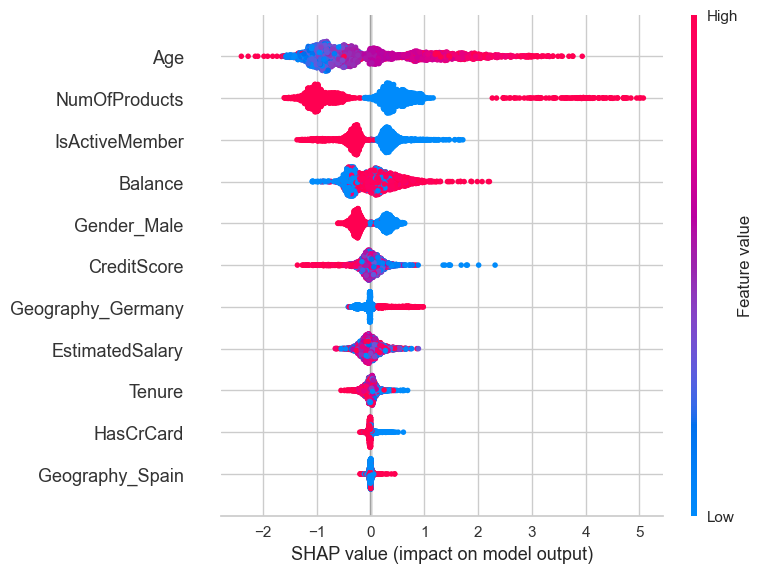

In [22]:
# Interpret Model
interpret_model(lightgbm, plot = 'summary')

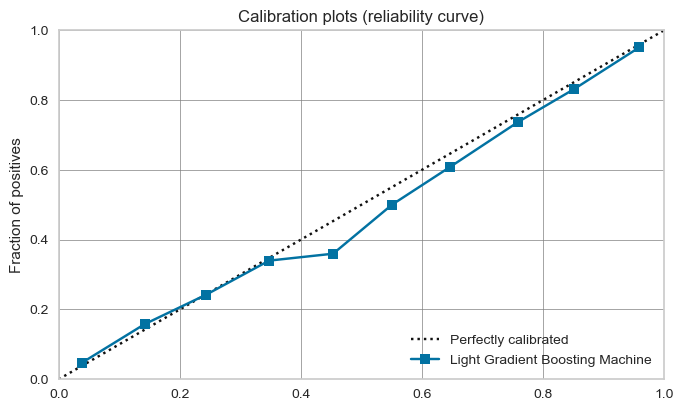

In [23]:
# Plot calibration curve
plot_model(lightgbm, plot = 'calibration')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8729,0.8630,0.5070,0.7912,0.6180,0.5461,0.5656
1,0.8743,0.8778,0.4859,0.8214,0.6106,0.5415,0.5680
2,0.8657,0.8630,0.5070,0.7500,0.6050,0.5278,0.5424
3,0.8686,0.8821,0.5070,0.7660,0.6102,0.5350,0.5515
4,0.8529,0.8715,0.4965,0.6961,0.5796,0.4934,0.5038
5,0.8700,0.8595,0.4825,0.8023,0.6026,0.5306,0.5551
6,0.8686,0.8355,0.4266,0.8592,0.5701,0.5027,0.5457
7,0.8414,0.8246,0.4266,0.6778,0.5236,0.4343,0.4511
8,0.8571,0.8198,0.4476,0.7529,0.5614,0.4826,0.5059


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

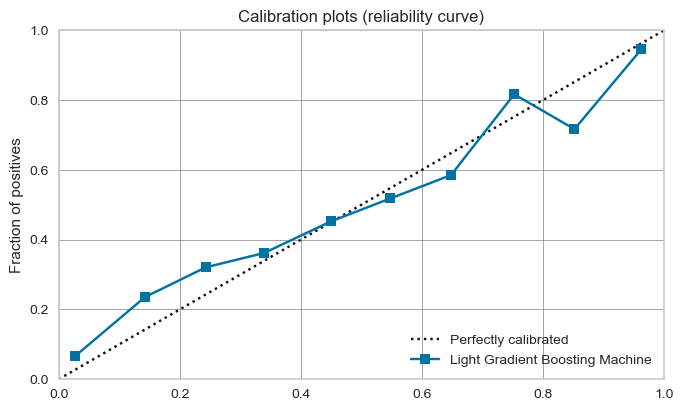

In [24]:
# Calibrate model
calibrated_lightgbm = calibrate_model(lightgbm)

# Plot calibration curve
plot_model(calibrated_lightgbm, plot = 'calibration')

Calibration resulted in an increase in Accuracy and Precision, but a slight decrease in both Recall and F1 scores. Since our goal is to improve our F1 score we use our original model instead.

In [25]:
# Predictions
predict_model(lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8653,0.8681,0.5106,0.7482,0.6070,0.5292,0.5433


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Exited,prediction_label,prediction_score
3564,847,51,5,97565.742188,1,0,0,144184.062500,0,0,1,1,1,0.6880
1986,845,41,2,81733.742188,2,0,0,199761.296875,1,0,0,0,0,0.9610
3684,482,35,2,133111.734375,1,0,1,79957.953125,0,0,0,0,0,0.9600
3334,671,27,5,0.000000,2,0,0,120893.070312,0,0,1,0,0,0.9936
8346,695,32,9,0.000000,3,0,1,38533.789062,0,1,1,0,0,0.9268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9164,680,36,7,0.000000,2,1,0,20109.210938,0,1,1,0,0,0.9839
364,640,68,9,0.000000,2,1,1,199493.375000,0,0,1,0,0,0.9929
3872,605,39,6,111169.906250,1,0,0,9641.400391,0,0,1,0,0,0.8555
3311,513,72,3,98903.062500,1,1,1,81251.242188,0,1,1,0,0,0.9662


In [26]:
# Save the model
save_model(lightgbm, 'my_best_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\USER\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['CreditScore', 'Age', 'Tenure',
                                              'Balance', 'NumOfProducts',
                                              'HasCrCard', 'IsActiveMember',
                                              'EstimatedSalary',
                                              'Geography_Germany',
                                              'Geography_Spain', 'Gender_Male'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               cop...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_depth=-1,
               

# Conclusion
Our original model had an F1 value of 0.5878 and even after tuning and calibrating it did not improve by much. However, the model performed better on the test set and the F1 value was 0.6070 which was better than the train set.